In [1]:
import pandas as pd
from DataCreation.DataLoader import load_df
import pywt
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
import cv2
import scipy.signal as sig
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
train = pd.read_parquet("TBData/tb_train.p")
test = pd.read_parquet("TBData/tb_test.p")
val = pd.read_parquet("TBData/tb_val.p")

In [4]:
maxlen = train["RSignalLen"].max()

train["padECG"] = train["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])
test["padECG"] = test["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])
val["padECG"] = val["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])

mean_ECG = np.mean(train["padECG"].values)
std_ECG = np.mean(test["padECG"].values)

In [5]:
maxlen

512

In [6]:
train["scaledECG"] = train["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)
test["scaledECG"] = test["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)
val["scaledECG"] = val["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)


train["welch"] = train["scaledECG"].apply(lambda x: welch(x)[1])
test["welch"] = test["scaledECG"].apply(lambda x: welch(x)[1])
val["welch"] = val["scaledECG"].apply(lambda x: welch(x)[1])

train["nwelch"] = train["welch"].apply(lambda x: x / np.sum(x))
test["nwelch"] = test["welch"].apply(lambda x: x / np.sum(x))
val["nwelch"] = val["welch"].apply(lambda x: x/ np.sum(x))

In [7]:
common_data = train.append(test).append(val).reset_index(drop=True)

In [8]:
common_data = common_data[~common_data["patient_id"].isin([4652, 4626])]

In [9]:
common_data.shape

(14673, 13)

In [10]:
def func(df):
    s = df.sample(2, random_state=15).reset_index()
    s['group'] = [ 'A', 'B']
    return s

common_data = train.append(test).append(val).reset_index(drop=True)
common_data = common_data[~common_data["patient_id"].isin([4652, 4626])]
common_data = common_data.drop_duplicates(subset=['cardiogram_id'])
d = common_data.patient_id.value_counts()
d = d[d>1] 
common_data = common_data[common_data.patient_id.isin(d.keys())].reset_index(drop=True)
data = common_data.groupby("patient_id", as_index=False).apply(func).reset_index(drop=True)
data_train = data[data["group"]=="A"].copy().reset_index(drop=True)
data_test = data[data["group"]=="B"].copy().reset_index(drop=True)
data_train = data_train.sample(frac=1, random_state=15).reset_index(drop=True)
data_test = data_test.sample(frac=1, random_state=15).reset_index(drop=True)


In [11]:
def create_scalogram(signal, level, filter_type):
    signal = np.pad(signal, [(0, 2**level  - len(signal))])
    #print(len(signal))
    dwt = pywt.swt(signal, filter_type, level=level)
    #print(len(dwt[0][1]))
    m = np.concatenate([x[1] for x in dwt]).reshape(-1, len(signal))
    
    #print(m.shape)
    s = np.sum(np.power(m, 2))
    m = np.power(m, 2) / (s * 1.0)
    #print(m.shape)
    return m


In [12]:
def new_create_scalogram(decrease_rate, signal, level, filter_type):
    #n = int(maxlen/ (2 ** level)) + 1
    #print(n)
    CA = signal
    for i in range(decrease_rate):
        CA, CD = pywt.dwt(CA, filter_type)
    signal = np.pad(CA, [(0, 2**level - len(CA))])
    #print(len(signal))
    dwt = pywt.swt(signal, filter_type, level=level)
    #print(len(dwt[0][1]))
    m = np.concatenate([x[1] for x in dwt]).reshape(-1, len(signal))
    
    #print(m.shape)
    s = np.sum(np.power(m, 2))
    m = np.power(m, 2) / (s * 1.0)
    #print(m.shape)
    return m

In [13]:
from tqdm import tqdm
import multiprocess as mp

In [14]:
def get_distance_matrix(train, test, distance):
    dist_matrix = np.zeros((test.shape[0], train.shape[0]))
    for i in tqdm(range(test.shape[0])):
        for j in range(train.shape[0]):
            dist_matrix[i,j] = distance(test[i] , train[j])
    return dist_matrix

In [15]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

/Users/valeria.guryanova/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [16]:
def emd_preparation(df_n, maxlen, df_train, df_test,
                    levels, filter_type, l1, l2, 
                    p_train, p_test,
                    write=False, rs="full", ):
    names = []
    df_train = df_train.copy()
    df_test = df_test.copy()
    #df_val = df_val.copy()
    df_train["scalogram"] = df_train["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[l1:l2])
    df_test["scalogram"] = df_test["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[l1:l2])
    #df_val["scalogram"] = df_val["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[-cut_levels:])
    matrix_shape = df_train["scalogram"][100].shape
    print(matrix_shape)
    df_train["scalogram"] = df_train["scalogram"].apply(lambda x: x.reshape(-1))
    df_test["scalogram"] = df_test["scalogram"].apply(lambda x: x.reshape(-1))
    #df_val["scalogram"] = df_val["scalogram"].apply(lambda x: x.reshape(-1))
    if write:
        name = df_n + "_" + "id_" + str(maxlen) +"_" + filter_type + "_" + str(levels) + "_"  + str(l1) + "_"  + str(l2) + "_" + str(rs) 
        name += "_" + str(matrix_shape[0]) + "_" + str(matrix_shape[1]) + "_" + str(p_train)
               
        name_train = "train" + "_" + name 
        name_test = "test" + "_" + name
        #name_val = "val" + "_" + name
        if rs != "full":
            name_test += "_" + str(p_test)
            #name_val += "_" + str(p_val)
        print(name_train)
        print(name_test)
        #print(name_val)
        names.append(name_train)
        #names.append(name_val)
        names.append(name_test)
        df_train.to_parquet("DistanceData/" + name_train + ".p")
        df_test.to_parquet("DistanceData/" + name_test + ".p")
        #df_val.to_parquet("DistanceData/" + name_val +".p")
    return df_train, df_test, names
            

In [18]:
import pywt

In [21]:
random_state = 11
train_size = 0.15
test_size = 0.3
val_size = 0.3
levels = 9
filter_type = "bior6.8"
l1 = 0
l2 = 7
df_n = "1"


df_train, df_test,  names = emd_preparation(df_n, maxlen, data_train, data_test, 
                                            levels, filter_type, l1, l2, 
                                            train_size, test_size,
                                            write=True, rs=random_state)



100%|██████████| 383/383 [00:01<00:00, 251.62it/s]


(7, 512)
train_1_id_512_bior6.8_9_0_7_11_7_512_0.15
test_1_id_512_bior6.8_9_0_7_11_7_512_0.15_0.3


In [ ]:
random_state = 11
train_size = 0.15
test_size = 0.3
val_size = 0.3
levels = 9
filter_type = "bior6.8"
l1 = 0
l2 = 8
df_n = "1"


df_train, df_test,  names = emd_preparation(df_n, maxlen, data_train, data_test, 
                                            levels, filter_type, l1, l2, 
                                            train_size, test_size,
                                            write=True, rs=random_state)

In [42]:
def get_scores(distance_matrix, df_train, df_test):
    #print(distance_matrix.shape)
    inds = np.argmin(distance_matrix, axis=1)
    #print(inds)
    preds = df_train["patient_id"][inds].values
    df_test["preds_id"] = preds
    true_values = df_test["patient_id"]
    acc = accuracy_score(true_values, preds)
    print("acc=", acc)
    preds = df_train["disease_info"][inds].values
    df_test["preds_d"] = preds
    true_values = df_test["disease_info"]
    f1 = f1_score(true_values, preds)
    print("f1=", f1)
    return acc, f1

In [22]:
def get_distance_matrix(train, test, distance):
    dist_matrix = np.zeros((test.shape[0], train.shape[0]))
    for i in tqdm(range(test.shape[0])):
        for j in range(train.shape[0]):
            dist_matrix[i,j] = distance(test[i] , train[j])
    return dist_matrix


distance_matrix_furie = get_distance_matrix(data_train["nwelch"],  data_test['nwelch'], wasserstein_distance)

100%|██████████| 383/383 [00:08<00:00, 42.56it/s]


In [23]:
get_scores(distance_matrix_furie, data_train, data_test)

acc= 0.031331592689295036
f1= 0.4156862745098039


(0.031331592689295036, 0.4156862745098039)

In [24]:
def get_scores_emd(name, df_train, df_test):
    alpha_values = [1.4, 1, 0.8, 0.5, 0.3, 0.2, 0.1, 0.07, 0.03, 0.001]
    accs = []
    f1s = []
    for i in alpha_values:
        d = pd.read_csv("DistanceData/" + name +"_" + str(i) + 
                        "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1).values
        #print(d.shape)
        acc, f1 = get_scores(d, df_train, df_test)
        accs.append(acc)
        f1s.append(f1)
    return accs , f1s, alpha_values
   

In [228]:
name = "test_1_id_512_bior6.8_9_0_7_11_7_512_0.15_0.3"
accs, f1s , alpha_values = get_scores_emd(name, data_train, data_test)
acc = np.max(accs)
ind = np.argmax(accs)
best_alpha1 = alpha_values[ind]
ind2 = np.argmax(f1s)
best_alpha2 = alpha_values[ind2]
print("accs_max=", acc)
print("f1 max=", max(f1s))

acc= 0.033942558746736295
f1= 0.44982698961937717
acc= 0.03655352480417755
f1= 0.45138888888888884
acc= 0.033942558746736295
f1= 0.4265734265734266
acc= 0.0391644908616188
f1= 0.45390070921985815
acc= 0.0391644908616188
f1= 0.46527777777777773
acc= 0.03655352480417755
f1= 0.4722222222222222
acc= 0.0391644908616188
f1= 0.49158249158249157
acc= 0.04177545691906005
f1= 0.5182724252491695
acc= 0.028720626631853787
f1= 0.48859934853420195
acc= 0.020887728459530026
f1= 0.5104895104895104
accs_max= 0.04177545691906005
f1 max= 0.5182724252491695


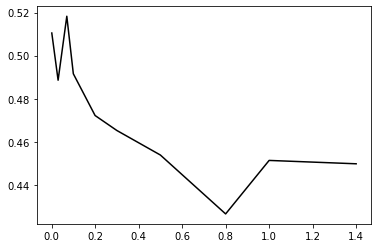

In [229]:
plt.plot(alpha_values, f1s, color="black")
plt.savefig('ResultImages/tb_f1_7_levels_alpha.png')

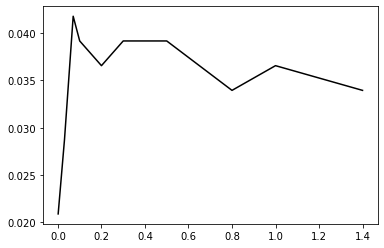

In [230]:
plt.plot(alpha_values, accs, color="black")
plt.savefig('ResultImages/tb_acc_7_levels_alpha.png')

In [41]:
print(best_alpha1)
print(best_alpha2)

0.07
0.07


In [44]:
name = "test_1_id_512_bior6.8_9_0_7_11_7_512_0.15_0.3"
d_emd = pd.read_csv("DistanceData/" + name +"_" + str(0.07) + 
                        "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1).values

4585
False


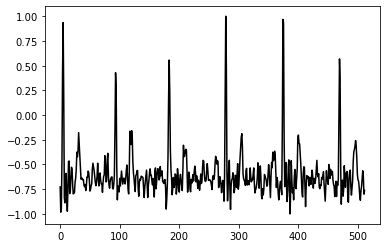

In [98]:
ind_test = 11
s_b = 0
s_len = 512
p_test = data_test["patient_id"][ind_test]
true_ind_train = data_train[data_train["patient_id"]==p_test].index[0]
ind_emd = np.argmin(d_emd[ind_test])
ind_furie = np.argmin(distance_matrix_furie[ind_test])
plt.plot(range(s_b, s_len), data_test["RECG_N"][ind_test][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_11_original.png')
print(data_test["patient_id"][ind_test])
print(data_test["disease_info"][ind_test])

4585
False


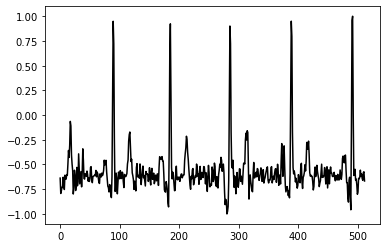

In [99]:
print(data_train["patient_id"][ind_emd])
print(data_train["disease_info"][ind_emd])
plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_emd][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_11_emd.png')

3712
False


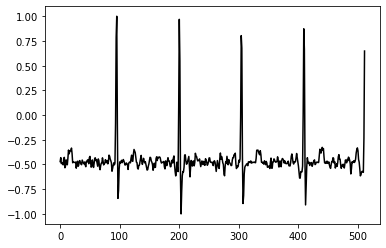

In [100]:
print(data_train["patient_id"][ind_furie])
print(data_train["disease_info"][ind_emd])
plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_furie][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_11_furie.png')

4562
False


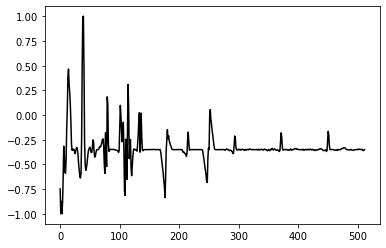

In [218]:
ind_test = 55
s_b = 0
s_len = 512
p_test = data_test["patient_id"][ind_test]
true_ind_train = data_train[data_train["patient_id"]==p_test].index[0]
ind_emd = np.argmin(d_emd[ind_test])
ind_furie = np.argmin(distance_matrix_furie[ind_test])
plt.plot(range(s_b, s_len), data_test["RECG_N"][ind_test][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_55_original.png')
print(data_test["patient_id"][ind_test])
print(data_test["disease_info"][ind_test])

4441
True


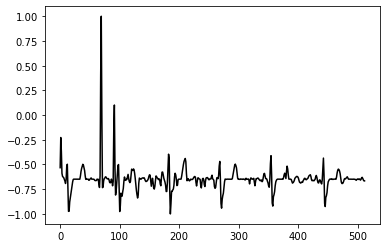

In [219]:
print(data_train["patient_id"][ind_emd])
print(data_train["disease_info"][ind_emd])
plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_emd][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_55_emd.png')

4310
True


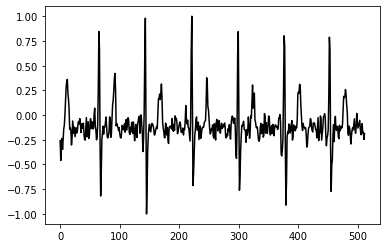

In [223]:
print(data_train["patient_id"][ind_furie])
print(data_train["disease_info"][ind_furie])
plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_furie][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_55_furie.png')

4562
False


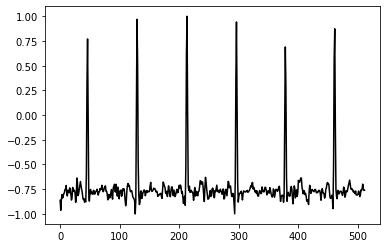

In [224]:
print(data_train["patient_id"][55])
print(data_train["disease_info"][55])
plt.plot(range(s_b, s_len), data_train["RECG_N"][55][s_b:s_len], color="black")
plt.savefig('ResultImages/tb_55_true_in_train.png')

In [76]:
#plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_train][s_b:s_len])

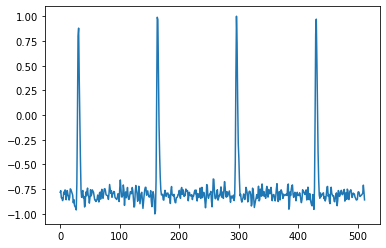

In [215]:
plt.plot(range(s_b, s_len), data_train["RECG_N"][ind_train_furie][s_b:s_len])

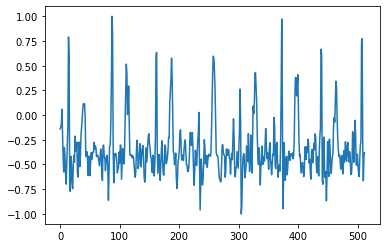

In [142]:
plt.plot(range(s_b, s_len), data_train["RECG_N"][true_ind_train][s_b:s_len])